# **OFA**
Start to enjoy image captioning with OFA! 

In [2]:
! pwd
%cd content
! pwd

/users/pgrad/mittalan/Desktop/dissertation/dissertation2022
/users/pgrad/mittalan/Desktop/dissertation/dissertation2022/content
/users/pgrad/mittalan/Desktop/dissertation/dissertation2022/content


In [3]:
# clone OFA if there does not exist the repo

! git clone https://github.com/OFA-Sys/OFA.git

Cloning into 'OFA'...
remote: Enumerating objects: 5921, done.
remote: Counting objects: 100% (684/684), done.
remote: Compressing objects: 100% (202/202), done.
remote: Total 5921 (delta 533), reused 552 (delta 478), pack-reused 5237
Receiving objects: 100% (5921/5921), 121.74 MiB | 24.84 MiB/s, done.
Resolving deltas: 100% (2241/2241), done.
Updating files: 100% (1190/1190), done.


## **Download Checkpoint**
We provide a link for our public checkpoint, and you only need to wget it to your workspace. We also provide an alternative below. Choose one as you like!

# Why did I even start to download the chkpnt when later on have to use tensorflow so there is no point? Have to use colab only for this, have to mount my google drive prior to doing that so that dont have to download again and again and again. This is a nightmare to maintain honestly. 

In [4]:

! mkdir -p /content/OFA/checkpoints/
# this does not happen so doing manually


mkdir: cannot create directory ‘/content’: Permission denied


In [ ]:
! wget https://ofa-silicon.oss-us-west-1.aliyuncs.com/checkpoints/caption_large_best_clean.pt
! mv caption_large_best_clean.pt OFA/checkpoints/caption.pt

BTW, if you cannot endure downloading (which might be slow if there are too many people downloading our checkpoint at the same time), we provide an alternative with Google Drive. 

First you need to manually put the checkpoint on your Google Drive by clicking the [URL](https://drive.google.com/file/d/1WBQl0WlzvdctslJyLNgedYpRrWAZC69X/view?usp=sharing) and clicking the bottom on the top right. 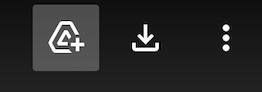

Then you just need to run the codes below without waiting:)

In [ ]:
from google.colab import drive
drive.mount('/content/Drive')
! mkdir -p /content/OFA/checkpoints
! ln -s /content/Drive/MyDrive/caption.pt /content/OFA/checkpoints/caption.pt

## **Install Fairseq**
We advise you to install fairseq by cloning the official repository and running "pip install". 

You should restart the window if you meet the hint of "RESTART RUNTIME". 

In [7]:
# clone Fairseq for installation
%cd content
! git clone https://github.com/pytorch/fairseq.git
%cd fairseq
! pip install --use-feature=in-tree-build ./

[Errno 2] No such file or directory: 'content'
/users/pgrad/mittalan/Desktop/dissertation/dissertation2022/content
fatal: destination path 'fairseq' already exists and is not an empty directory.
/users/pgrad/mittalan/Desktop/dissertation/dissertation2022/content/fairseq

Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

option --use-feature: invalid choice: 'in-tree-build' (choose from '2020-resolver', 'fast-deps', 'truststore')


## **Preparation**
Below you just need to import required packages, and check whether to use GPU or FP16. 

In [8]:
!pwd

/users/pgrad/mittalan/Desktop/dissertation/dissertation2022/content/fairseq


In [9]:
%cd ..
%cd OFA

/users/pgrad/mittalan/Desktop/dissertation/dissertation2022/content
/users/pgrad/mittalan/Desktop/dissertation/dissertation2022/content/OFA


In [10]:
%cd /content/OFA
! sed '1d' requirements.txt | xargs -I {} pip install {}

[Errno 2] No such file or directory: '/content/OFA'
/users/pgrad/mittalan/Desktop/dissertation/dissertation2022/content/OFA


In [11]:
import torch
import numpy as np
from fairseq import utils,tasks
from fairseq import checkpoint_utils
from utils.eval_utils import eval_step
from tasks.mm_tasks.caption import CaptionTask
from models.ofa import OFAModel
from PIL import Image

# Register caption task
tasks.register_task('caption',CaptionTask)

# turn on cuda if GPU is available
use_cuda = torch.cuda.is_available()
# use fp16 only when GPU is available
use_fp16 = False

/users/pgrad/mittalan/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'utils' from 'fairseq' (unknown location)

## **Build Model**
Below you can build your model and load the weights from the given checkpoint, and also build a generator. 

In [ ]:
# Load pretrained ckpt & config
overrides={"bpe_dir":"utils/BPE", "eval_cider":False, "beam":5, "max_len_b":16, "no_repeat_ngram_size":3, "seed":7}
models, cfg, task = checkpoint_utils.load_model_ensemble_and_task(
        utils.split_paths('checkpoints/caption.pt'),
        arg_overrides=overrides
    )

# Move models to GPU
for model in models:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

# Initialize generator
generator = task.build_generator(models, cfg.generation)

## **Preprocess**
We demonstrate the required transformation fucntions for preprocessing inputs.

In [ ]:
# Image transform
from torchvision import transforms
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((cfg.task.patch_image_size, cfg.task.patch_image_size), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Text preprocess
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()
def encode_text(text, length=None, append_bos=False, append_eos=False):
    s = task.tgt_dict.encode_line(
        line=task.bpe.encode(text),
        add_if_not_exist=False,
        append_eos=False
    ).long()
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s])
    if append_eos:
        s = torch.cat([s, eos_item])
    return s

# Construct input for caption task
def construct_sample(image: Image):
    patch_image = patch_resize_transform(image).unsqueeze(0)
    patch_mask = torch.tensor([True])
    src_text = encode_text(" what does the image describe?", append_bos=True, append_eos=True).unsqueeze(0)
    src_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in src_text])
    sample = {
        "id":np.array(['42']),
        "net_input": {
            "src_tokens": src_text,
            "src_lengths": src_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask
        }
    }
    return sample
  
# Function to turn FP32 to FP16
def apply_half(t):
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

## **Run Inference**
Download an image and run the following scripts to generate the caption.

In [ ]:
# Download an image from COCO or you can use other images with wget
! wget http://farm4.staticflickr.com/3539/3836680545_2ccb331621_z.jpg 
! mv 3836680545_2ccb331621_z.jpg  test.jpg
image = Image.open('./test.jpg')

# Construct input sample & preprocess for GPU if cuda available
sample = construct_sample(image)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

In [ ]:
# Run eval step for caption
with torch.no_grad():
    result, scores = eval_step(task, generator, models, sample)

In [ ]:
display(image)
print('Caption: {}'.format(result[0]['caption']))
